# Monitoring

Here, we are going to use Amazon SageMaker model monitor to add continuous and automated monitoring of the data quality for the traffic to your real-time SageMaker inference endpoints. You also implement model monitoring to detect performance drift and model metric anomalies.

Using Model Monitor integration with Amazon EventBridge you can implement automated response and remediation to any detected issues with data and model quality. For example, you can launch an automated model retraining if the model performance falls below a specific threshold.

In [2]:
%pip install jsonlines tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import boto3
import botocore
import sagemaker 
import json
import jsonlines
import random
from tqdm import trange
from sagemaker.predictor import Predictor
from sagemaker import ModelPackage
import time
from time import gmtime, strftime
from datetime import datetime, timezone, timedelta
import uuid
import pandas as pd
import numpy as np
from sagemaker.model_monitor import (
    DefaultModelMonitor,
    DataCaptureConfig,
    CronExpressionGenerator,
    ModelQualityMonitor,
    EndpointInput,
)
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.model_monitor import DataCaptureConfig
from monitoring_utils import run_model_monitor_job
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.clarify import (
    BiasConfig,
    DataConfig,
    ModelConfig,
    ModelPredictedLabelConfig,
    SHAPConfig,
)
from urllib.parse import urlparse

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


'2.205.0'

In [4]:
sm = boto3.client("sagemaker")
s3 = boto3.client("s3")

In [5]:
session = sagemaker.Session()

In [6]:
pd.set_option("display.max_colwidth", None)

In [7]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN setup.ipynb notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Stored variables and their in-db values:
baseline_s3_url                        -> 's3://mathujan-mlops-project/mlproject/xgboost/bas
bucket_name                            -> 'mathujan-mlops-project'
bucket_prefix                          -> 'mlproject/xgboost'
domain_id                              -> 'd-ywcadzjrpjyt'
evaluation_s3_url                      -> 's3://mathujan-mlops-project/mlproject/xgboost/eva
initialized                            -> True
input_s3_url                           -> 's3://mathujan-mlops-project/mlproject/xgboost/inp
model_package_group_name               -> 'mathujan-mlproject-model-group'
output_s3_url                          -> 's3://mathujan-mlops-project/mlproject/xgboost/out
prediction_baseline_s3_url             -> 's3://mathujan-mlops-project/mlproject/xgboost/pre
region                                 -> 'eu-north-1'
sm_role                                -> 'arn:aws:iam::975049938031:role/service-role/Amazo
test_s3_url                         

## How Model Monitor works
Amazon SageMaker Model Monitor automatically monitors ML models in production and notifies you when quality issues arise. Model Monitor uses rules to detect drift in your models and data and alerts you when it happens. The following figure shows how this process works.

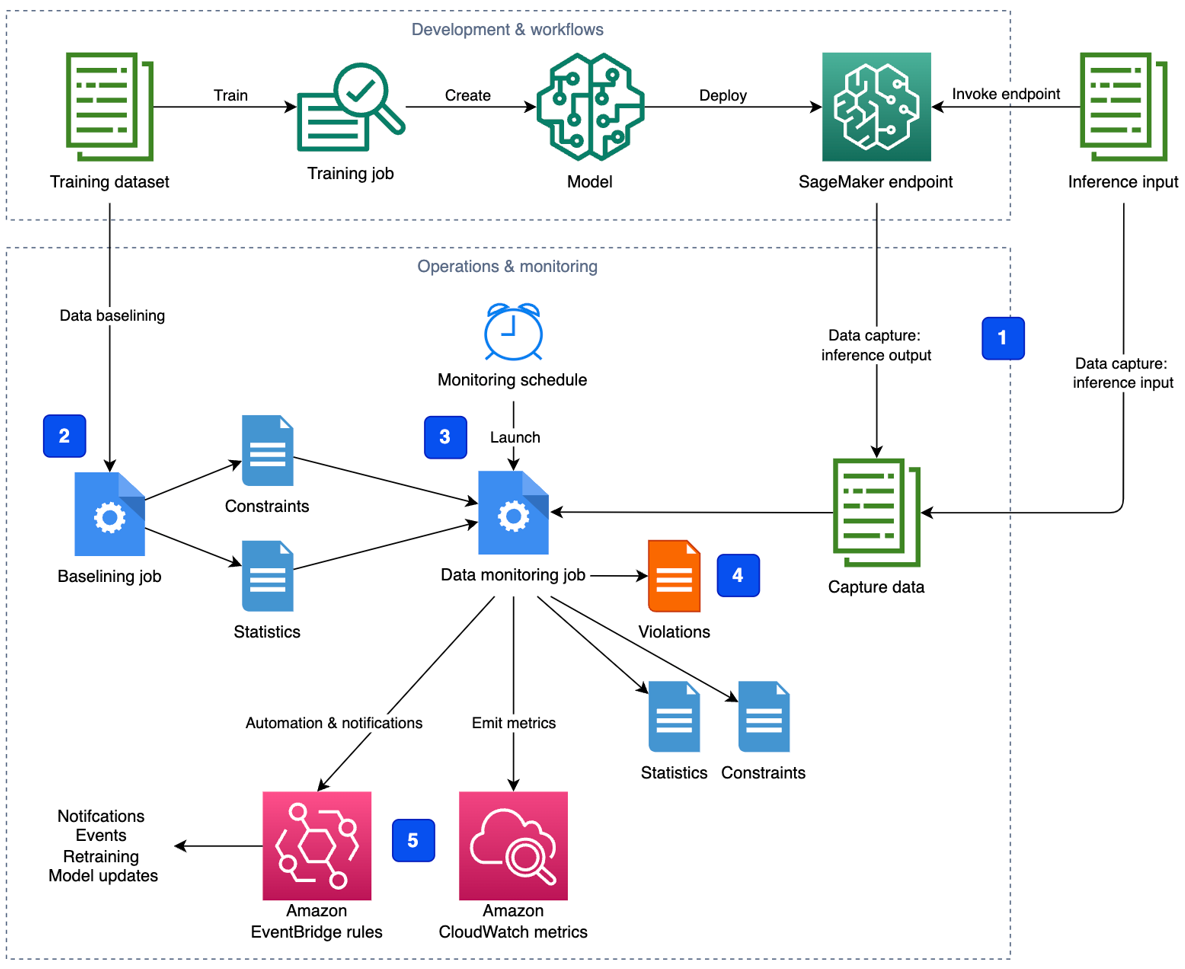

The process for setting up and using the data monitoring:
1. Enable the SageMaker endpoint to capture data from incoming requests to a trained ML model and the resulting model predictions
2. Create a baseline from the dataset that was used to train the model. The baseline computes metrics and suggests constraints for the metrics. 
3. Create a monitoring schedule specifying what data to collect, how often to collect it, and how to analyze it. Data traffic to your model and predictions from the model are compared to the constraints, and are reported as violations if they are outside the constrained values. You can define multiple monitoring schedule per endpoint
4. Inspect the reports, which compare the latest data with the baseline, and watch for any violations reported and for metrics and notifications from Amazon CloudWatch
5. Implement observability for your ML models with Amazon CloudWatch and event-based architecture with Amazon EventBridge. You can automate data and model updates, model retraining, and user notification based on the data and model quality events

## Real-time inference data capture from a SageMaker endpoint
Here, we need a real-time inference endpoint and data capture configured on that endpoint. 
If we don't have an active endpoint, we need to create one.

In [8]:
# List all deployed real-time endpoints. Depending on your existing environment you might have multiple endpoints
endpoints = sm.list_endpoints(StatusEquals="InService")["Endpoints"]
endpoint_name = ""

if not len(endpoints):
    print(f"There is no deployed active endpoints. You must have at least one endpoint. Run the pipeline to create a model")
else:
    endpoint_name = endpoints[0]['EndpointName']
    print(f"There are {len(endpoints)} active inference endpoints. Checking the data capture configuration:")
    
for ep in endpoints:
    print(f"Data capture configuration for {ep['EndpointName']}:")
    print(f"{json.dumps(sm.describe_endpoint(EndpointName=ep['EndpointName'])['DataCaptureConfig'], indent=2)}")

There is no deployed active endpoints. You must have at least one endpoint. Run the pipeline to create a model


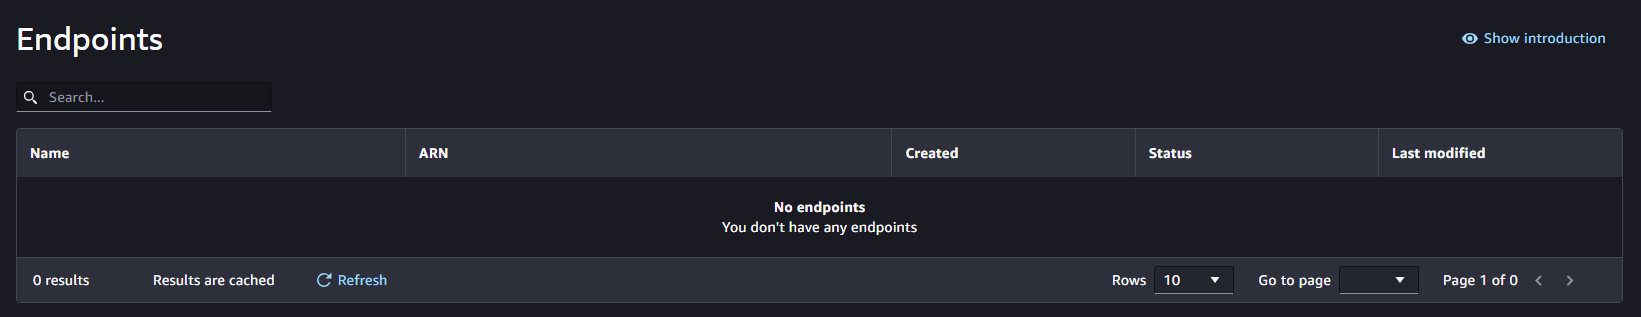

### Deploy a model from the model registry as a real-time endpoint
Create an endpoint with a model from the model registry.

The following code checks if there is a model package group created by the pipeline and if there are any registered model versions in the package.

In [9]:
try:
    model_package_group = sm.describe_model_package_group(ModelPackageGroupName=model_package_group_name)
    print(f"There is model package group {model_package_group_name} in the model registry")
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print("******* ERROR *********")
        print(f"Model package group with the name {model_package_group_name} is not found. You need to run the pipeline to create a model")

There is model package group mathujan-mlproject-model-group in the model registry


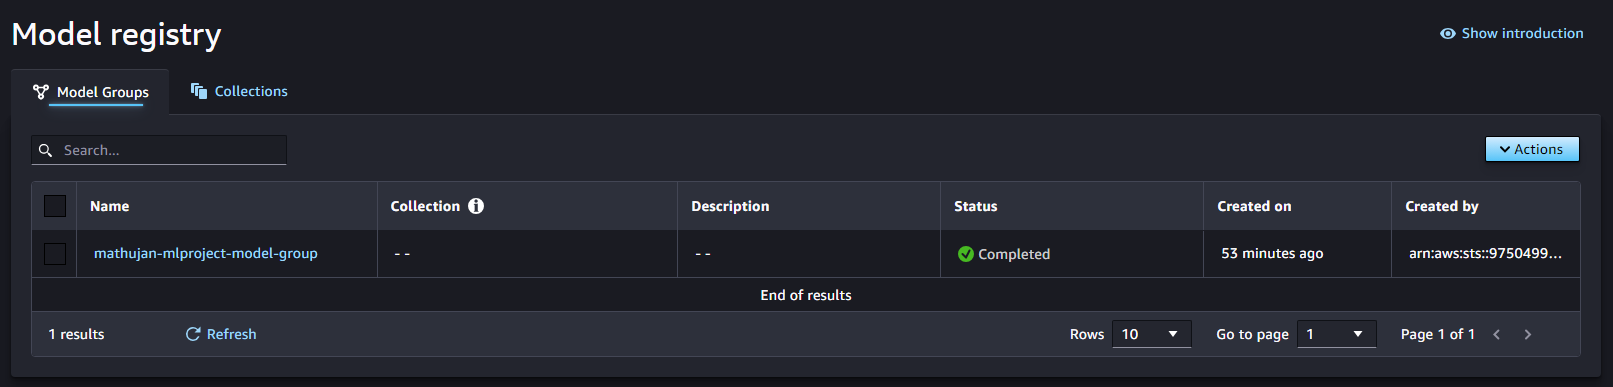

In [10]:
model_packages = []

# Find the latest model package
# Set the parameter ModelApprovalStatus='Approved' if you'd like to get only the approved packages
# Sort by the CreationTime
for p in sm.get_paginator('list_model_packages').paginate(
    ModelPackageGroupName=model_package_group_name,
    # ModelApprovalStatus='Approved',
    SortBy="CreationTime",
    SortOrder="Descending",
    ):
    model_packages.extend(p["ModelPackageSummaryList"])
    
if not len(model_packages):
    print("There is no model packages in the model package group {}. You need to run the pipeline to create a model")
    
latest_model_package_arn = model_packages[0]['ModelPackageArn']
print(f"The latest model package is version {model_packages[0]['ModelPackageVersion']}, {latest_model_package_arn}")


The latest model package is version 2, arn:aws:sagemaker:eu-north-1:975049938031:model-package/mathujan-mlproject-model-group/2


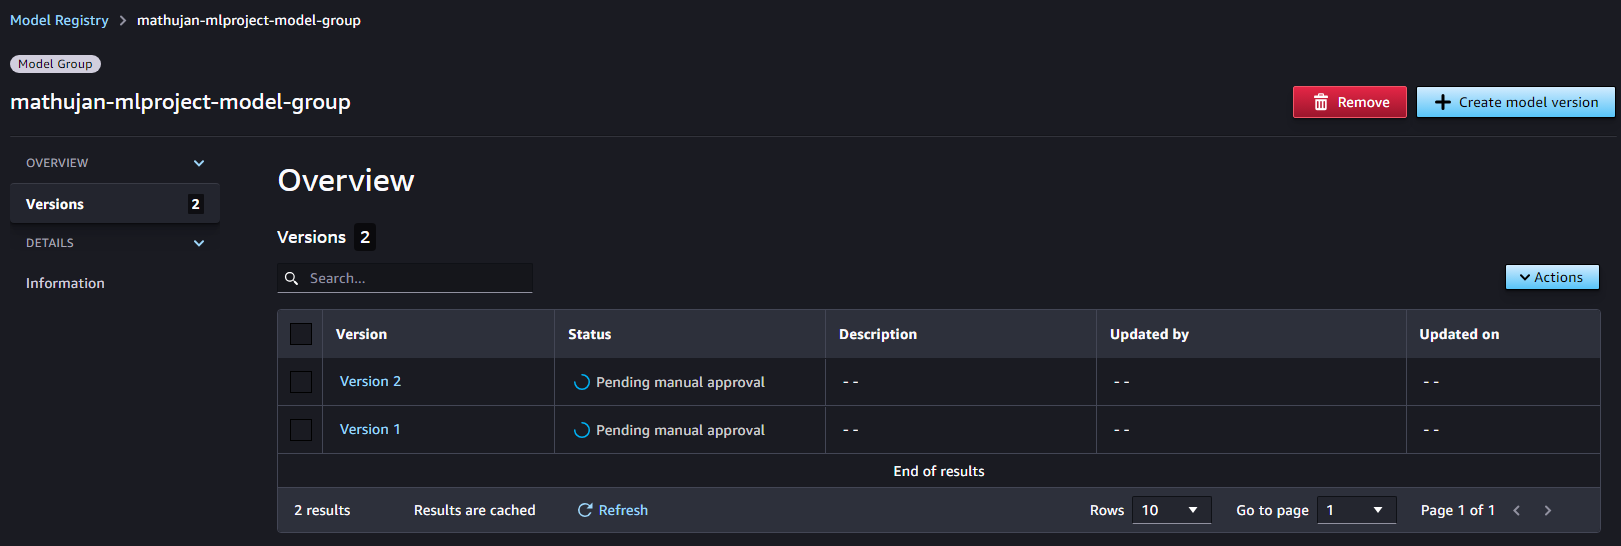

You can only deploy a model with the model approval status `Approved`, so the next code cell updates the status.

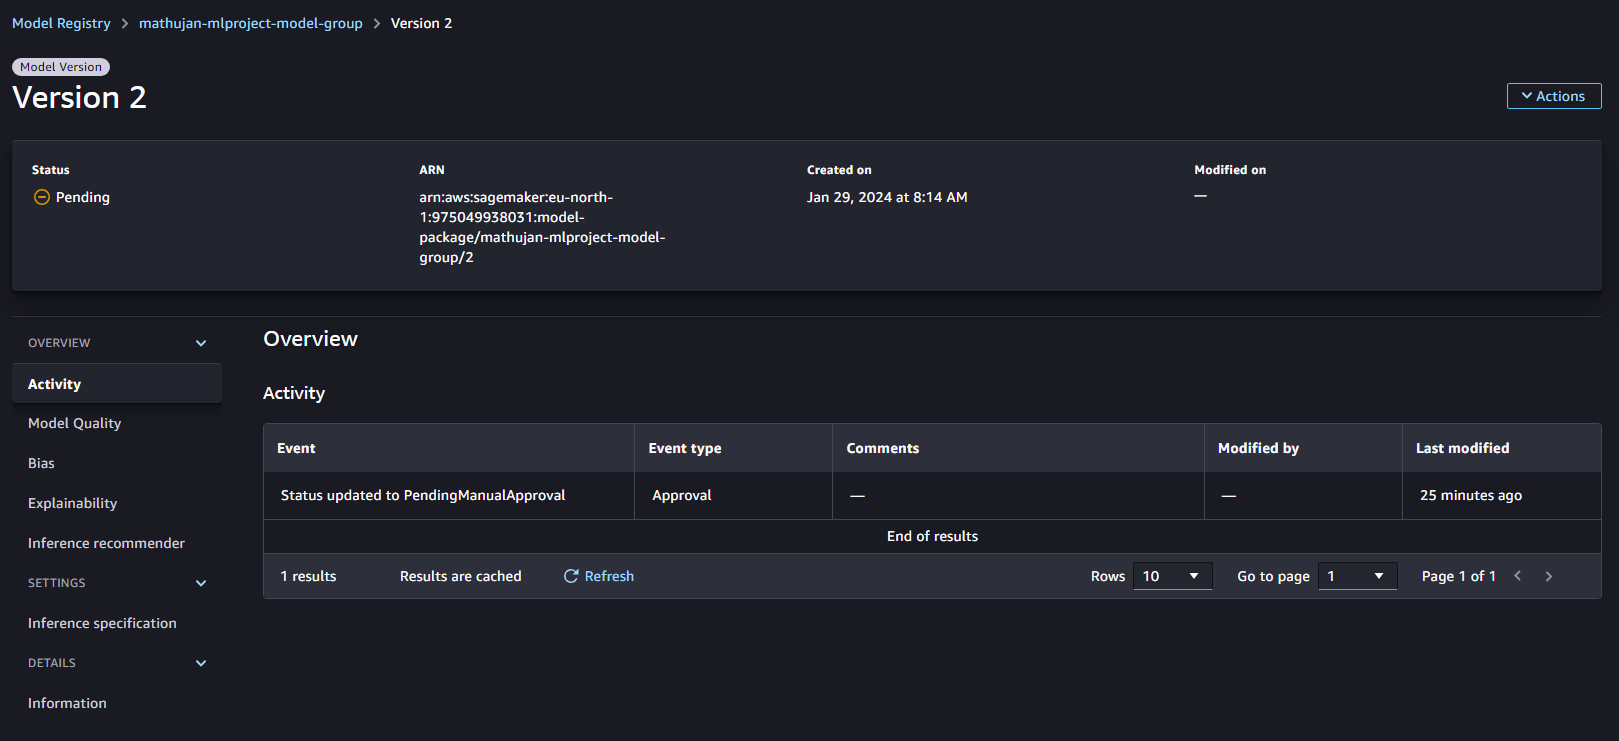

In [11]:
sm.update_model_package(
    ModelPackageArn=latest_model_package_arn,
    ModelApprovalStatus="Approved",
)

{'ModelPackageArn': 'arn:aws:sagemaker:eu-north-1:975049938031:model-package/mathujan-mlproject-model-group/2',
 'ResponseMetadata': {'RequestId': 'fc7b8d4d-2a18-45b6-b614-fed8219873d4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fc7b8d4d-2a18-45b6-b614-fed8219873d4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '110',
   'date': 'Mon, 29 Jan 2024 03:10:15 GMT'},
  'RetryAttempts': 0}}

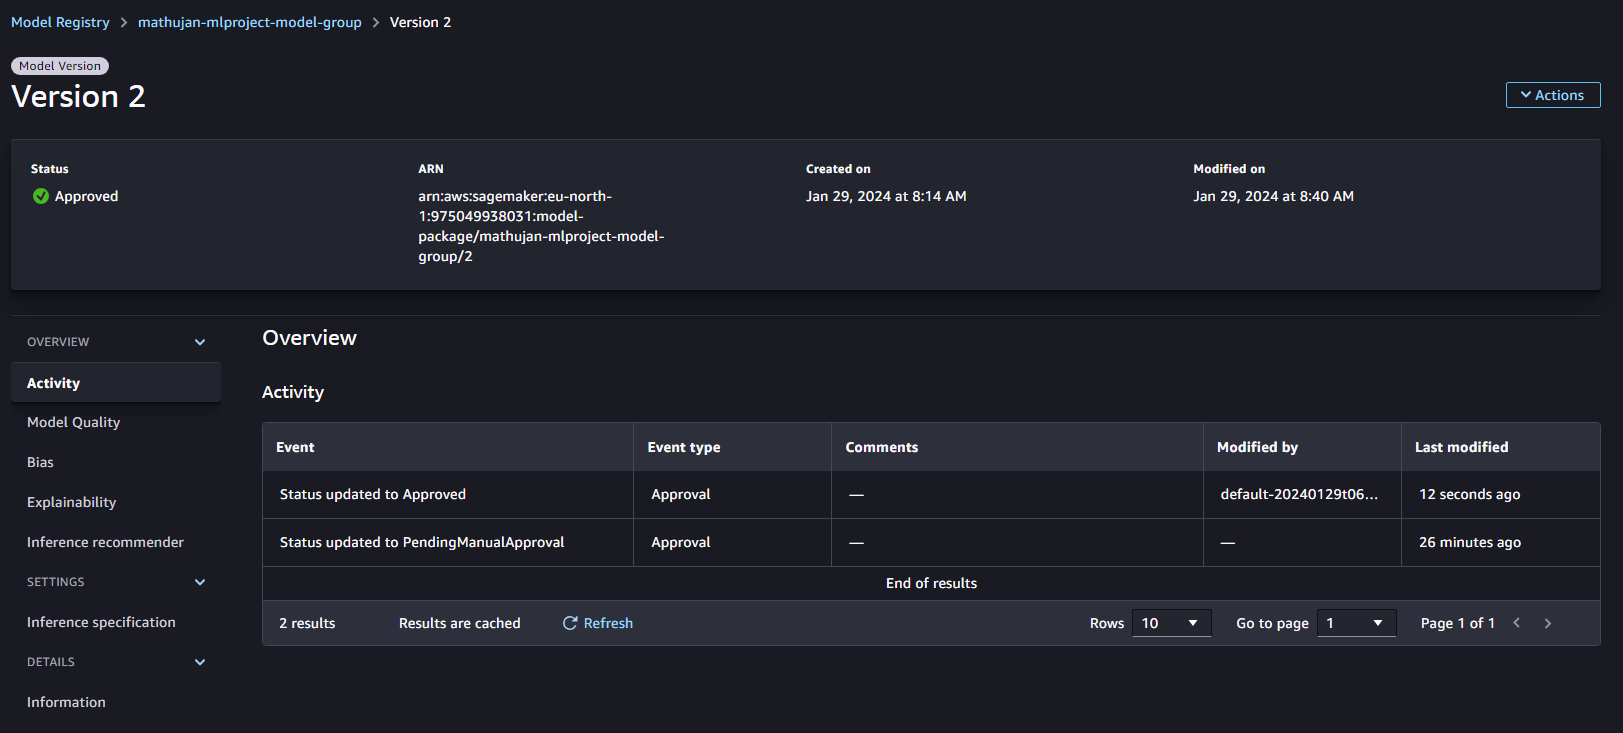

In [12]:
# Create a model from the registry using Python SDK
model = ModelPackage(role=sm_role, 
                     model_package_arn=model_packages[0]['ModelPackageArn'], 
                     sagemaker_session=session)

In [13]:
# Set the timezone to IST (Indian Standard Time)
ist = timezone(timedelta(hours=5, minutes=30))

# Get the current time in IST
ist_time = datetime.now(ist)

# Format the IST time and use it in the endpoint_name
endpoint_name = f"mathujan-mlproject-endpoint-{ist_time.strftime('%d-%H-%M-%S')}"

data_capture_config = DataCaptureConfig(
            enable_capture=True,
            sampling_percentage=100,
            destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
            csv_content_types=["text/csv"],
        )

In [14]:
# Deploy the model
model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    wait=False,
    data_capture_config=data_capture_config,
    endpoint_name=endpoint_name,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

In [15]:
# Wait until the endpoint has the status InService, it takes approximately 5 min
waiter = session.sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

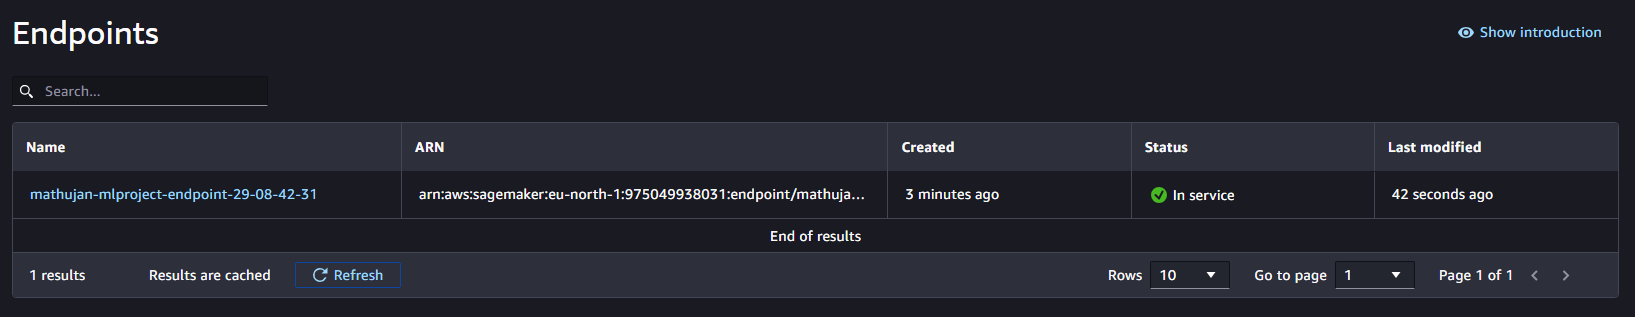

### Check the data capture configuration

In [16]:
# Get the data capture configuration for the endpoint
# endpoint_name = "mathujan-mlproject-endpoint-28-12-06-12" # must be set before, but you can use any suitable endpoint

if not endpoint_name:
    print(f"You must have at least on endpoint with data capture configuration enabled!")
else:
    print(f"Checking the data capture configuration for the endpoint {endpoint_name}")
    data_capture_config = sm.describe_endpoint(EndpointName=endpoint_name)['DataCaptureConfig']
    data_capture_s3_url = data_capture_config['DestinationS3Uri']
    data_capture_bucket = data_capture_s3_url.split('/')[2]
    data_capture_prefix = '/'.join(data_capture_s3_url.split('/')[3:])

    print(json.dumps(data_capture_config, indent=2))
    print(f"Data capture S3 url: {data_capture_s3_url}")

Checking the data capture configuration for the endpoint mathujan-mlproject-endpoint-29-08-42-31
{
  "EnableCapture": true,
  "CaptureStatus": "Started",
  "CurrentSamplingPercentage": 100,
  "DestinationS3Uri": "s3://mathujan-mlops-project/mlproject/xgboost/data-capture"
}
Data capture S3 url: s3://mathujan-mlops-project/mlproject/xgboost/data-capture


### Define helper functions
Define some helper functions with code snippets that we're going to use throughout this notebook.

In [17]:
# Send data to the endpoint
def generate_endpoint_traffic(predictor, data):
    l = len(data)
    for i in trange(l):
        predictions = np.array(predictor.predict(data.iloc[i].values), dtype=float).squeeze()

In [18]:
# Get all file keys under a specified prefix
def get_file_list(bucket, prefix):
    try:
        files = [f.get("Key") for f in s3.list_objects(Bucket=bucket, Prefix=prefix).get("Contents")]
        print(f"Found {len(files)} files in s3://{bucket}/{prefix}")
        
        return files
    except TypeError:
        print(f"No files found in s3://{bucket}/{prefix}")
        return []

In [19]:
# Get S3 url for the latest captured data
def get_latest_data_capture_s3_url(bucket, prefix):
    capture_files = get_file_list(bucket, prefix)
    
    if capture_files:
        latest_data_capture_s3_url = f"s3://{bucket}/{'/'.join(capture_files[-1].split('/')[:-1])}"

        print(f"Latest data capture S3 url: {latest_data_capture_s3_url}")
        
        return latest_data_capture_s3_url
    else:
        return None

In [20]:
# Get S3 url for the latest monitoring job output
def get_latest_monitoring_report_s3_url(job_name):
    monitor_job = sm.list_processing_jobs(
        NameContains=job_name,
        SortOrder='Descending',
        MaxResults=2
    )['ProcessingJobSummaries'][0]['ProcessingJobName']

    monitoring_job_output_s3_url = sm.describe_processing_job(
        ProcessingJobName=monitor_job
    )['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']

    print(f"Latest monitoring report S3 url: {monitoring_job_output_s3_url}")
    
    return monitoring_job_output_s3_url

In [21]:
# Helper to load a json file from S3
def load_json_from_file(file_s3_url):
    bucket = file_s3_url.split('/')[2]
    key = '/'.join(file_s3_url.split('/')[3:])
    print(f"Load JSON from: {bucket}/{key}")
    
    return json.loads(
        s3.get_object(Bucket=bucket, 
                      Key=key)["Body"].read().decode("utf-8")
    )

In [22]:
def get_latest_monitor_execution(monitor):
    mon_executions = monitor.list_executions()

    if len(mon_executions):
        latest_execution = mon_executions[-1]  # get the latest execution
        latest_execution.wait(logs=False)

        print(f"Latest execution status: {latest_execution.describe().get('ProcessingJobStatus')}")
        print(f"Latest execution result: {latest_execution.describe().get('ExitMessage')}")

        latest_job = latest_execution.describe()
        if latest_job["ProcessingJobStatus"] != "Completed":
            print("No completed executions to inspect further")
        else:
            report_uri = latest_execution.output.destination
            print(f"Report Uri: {report_uri}")
        
        return latest_execution
    else:
        print("No monitoring schedule executions found")
        return None

### Generate endpoint traffic and captured data
We must send some data to an endpoint for inference to generate data capture. If we need to add or update the data capture configuration for the endpoint, we can use `DataCaptureConfig` and call `update_data_capture_config()` method of the predictor.

In [23]:
# Create a predictor class for the endpoint
predictor = Predictor(
    endpoint_name=endpoint_name, 
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer()
)

# Update data capture config for settings we use in this notebook
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=data_capture_s3_url,
    csv_content_types=["text/csv"],
)

predictor.update_data_capture_config(data_capture_config)

----!

Use test dataset produced by the pipeline and saved on the EFS volume:

In [24]:
!aws s3 cp $test_s3_url/test_x.csv tmp/test_x.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://mathujan-mlops-project/mlproject/xgboost/test/test_x.csv to tmp/test_x.csv
download: s3://mathujan-mlops-project/mlproject/xgboost/test/test_y.csv to tmp/test_y.csv


In [25]:
# Set the number of data vectors from the test dataset sent to the inference endpoint
number_of_vectors = 100

In [26]:
test_x = pd.read_csv("tmp/test_x.csv", names=[f'_c{i}' for i in range(59)]).sample(number_of_vectors)

In [27]:
test_x.head(1)

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c49,_c50,_c51,_c52,_c53,_c54,_c55,_c56,_c57,_c58
3239,42,2,999,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


Send the data to the endpoint:

In [28]:
generate_endpoint_traffic(predictor, test_x)

100%|██████████| 100/100 [00:01<00:00, 62.98it/s]


### View captured data
Now list the data capture files stored in Amazon S3. The data is stored as `jsonl` an Amazon S3 path format is `s3://{data-capture-destination-s3-url}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`.

Wait until captured data appears in the Amazon S3 bucket, it may take several minutes.

In [34]:
!aws s3 ls {data_capture_s3_url} --recursive

2024-01-29 03:22:19      48697 mlproject/xgboost/data-capture/mathujan-mlproject-endpoint-29-08-42-31/AllTraffic/2024/01/29/03/21-11-944-de9fb9f8-0c96-4b10-af77-36e47d520729.jsonl


In [35]:
capture_files = get_file_list(data_capture_bucket, data_capture_prefix)

Found 1 files in s3://mathujan-mlops-project/mlproject/xgboost/data-capture


In [36]:
assert len(capture_files) > 0, "Wait until the capture data delivered to the Amazon S3 bucket"

In [37]:
capture_files[0]

'mlproject/xgboost/data-capture/mathujan-mlproject-endpoint-29-08-42-31/AllTraffic/2024/01/29/03/21-11-944-de9fb9f8-0c96-4b10-af77-36e47d520729.jsonl'

In [38]:
# Download a capture data file and print it's content
file_key = capture_files[-1]
S3Downloader.download(f"s3://{data_capture_bucket}/{file_key}", f"./tmp")

print(f"Content of the capture file:")
# Read the jsonl file and show the first object
with jsonlines.open(f"./tmp/{file_key.split('/')[-1]}") as reader:      
    print(json.dumps(reader.read(), indent=2))
    # print(json.dumps(reader.read(), indent=2))

Content of the capture file:
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "42,2,999,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.03709780052304268\n",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "3e2f61b0-76a2-4007-b449-b2cf3479bc56",
    "inferenceTime": "2024-01-29T03:21:11Z"
  },
  "eventVersion": "0"
}


## Monitor data quality
Setup the data quality monitoring for SageMaker real-time endpoints.

To enable inference data quality monitoring and evaluation we must:
1. Enable data capture
1. Create a baseline with which you compare the realtime traffic
1. Once a baseline is ready, schedule monitoring jobs to continously evaluate and compare against the baseline
1. See and interpret the results of monitoring jobs
1. Integrate data quality monitoring with Amazon CloudWatch

### Create a baselining job with the training dataset
The whole dataset with which you trained and tested the model is usually a good baseline dataset. Note that the baseline dataset data schema and the inference dataset schema should exactly match (i.e. the number and order of the features).

From the baseline dataset you can ask Amazon SageMaker to suggest a set of baseline _constraints_ and generate descriptive _statistics_ to explore the data. Model Monitor provides a built-in container that provides the ability to suggest the constraints automatically for CSV and flat JSON input. This `sagemaker-model-monitor-analyzer` container also provides you with a range of model monitoring capabilities, including constraint validation against a baseline, and emitting Amazon CloudWatch metrics. This container is based on Spark and is built with Deequ. 

All column names in your baseline dataset must be compliant with Spark. For column names, use only lowercase characters, and _ as the only special character. 

Use the baseline dataset we created in the data processing. The baseline dataset is the full dataset without header, index, and label column.

In [39]:
!aws s3 ls {baseline_s3_url}/

2024-01-29 02:27:58    4982068 baseline.csv


In [40]:
baseline_results_s3_url = f"{baseline_s3_url}/results"
data_mon_reports_s3_url = f"{baseline_s3_url}/reports"
baseline_dataset_uri = f"{baseline_s3_url}/baseline.csv"

Use the Python SDK class `DefaultModelMonitor` to create a data monitor and interact with it:

In [51]:
data_monitor = DefaultModelMonitor(
    role=sm_role,
    instance_count=4,
    instance_type="ml.t3.medium",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=session,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Start a SageMaker processing job on the baseline data to profile data and suggest constraints.

In [52]:
# Set the timezone to IST (Indian Standard Time)
ist = timezone(timedelta(hours=5, minutes=30))

# Get the current time in IST
ist_time = datetime.now(ist)

data_baseline_job_name = f"mathujan-mlproject-data-baselining-{ist_time.strftime('%d-%H-%M-%S')}-{str(uuid.uuid4())[:8]}"

data_baseline_job = data_monitor.suggest_baseline(
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=False),
    output_s3_uri=baseline_results_s3_url,
    wait=False,
    logs=False,
    job_name=data_baseline_job_name,
)

print(data_baseline_job_name)

INFO:sagemaker:Creating processing-job with name mathujan-mlproject-data-baselining-29-09-25-43-24d7d074


mathujan-mlproject-data-baselining-29-09-25-43-24d7d074


In [ ]:
data_baseline_job.wait(logs=False)

.......................................................................................................................................................................................................................................................................................!

### See the generated statistics and constraints
After the baselining jobs finished, it saves the baseline statistics to the `statistics.json` file and the suggested baseline constraints to the `constraints.json` file in the location we specify with `output_s3_uri`.

In [54]:
data_monitor.describe_latest_baselining_job()

{'ProcessingInputs': [{'InputName': 'baseline_dataset_input',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://mathujan-mlops-project/mlproject/xgboost/baseline/baseline.csv',
    'LocalPath': '/opt/ml/processing/input/baseline_dataset_input',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'monitoring_output',
    'S3Output': {'S3Uri': 's3://mathujan-mlops-project/mlproject/xgboost/baseline/results',
     'LocalPath': '/opt/ml/processing/output',
     'S3UploadMode': 'EndOfJob'},
    'AppManaged': False}]},
 'ProcessingJobName': 'mathujan-mlproject-data-baselining-29-09-25-43-24d7d074',
 'ProcessingResources': {'ClusterConfig': {'InstanceCount': 4,
   'InstanceType': 'ml.t3.medium',
   'VolumeSizeInGB': 20}},
 'StoppingCondition': {'MaxRuntimeInSeconds': 3600},
 'AppSpecification': {'ImageUri': '895015795356.dkr.ecr.eu-north-1.amazon

In [55]:
!aws s3 ls {baseline_results_s3_url}/

2024-01-29 04:19:41       9368 constraints.json
2024-01-29 04:19:41    1491714 statistics.json


In [56]:
data_statistics_s3_url = f"{baseline_results_s3_url}/statistics.json"
data_constraints_s3_url = f"{baseline_results_s3_url}/constraints.json"

Copy statistics and constraints JSON files to the Studio EFS:

In [57]:
!aws s3 cp {data_constraints_s3_url} ./tmp/
!aws s3 cp {data_statistics_s3_url} ./tmp/

download: s3://mathujan-mlops-project/mlproject/xgboost/baseline/results/constraints.json to tmp/constraints.json
download: s3://mathujan-mlops-project/mlproject/xgboost/baseline/results/statistics.json to tmp/statistics.json


In [58]:
!head -20 tmp/constraints.json

{
  "version" : 0.0,
  "features" : [ {
    "name" : "_c0",
    "inferred_type" : "Integral",
    "completeness" : 1.0,
    "num_constraints" : {
      "is_non_negative" : true
    }
  }, {
    "name" : "_c1",
    "inferred_type" : "Integral",
    "completeness" : 1.0,
    "num_constraints" : {
      "is_non_negative" : true
    }
  }, {
    "name" : "_c2",
    "inferred_type" : "Integral",
    "completeness" : 1.0,


In [59]:
!head -20 tmp/statistics.json

{
  "version" : 0.0,
  "dataset" : {
    "item_count" : 41188
  },
  "features" : [ {
    "name" : "_c0",
    "inferred_type" : "Integral",
    "numerical_statistics" : {
      "common" : {
        "num_present" : 41188,
        "num_missing" : 0
      },
      "mean" : 40.02406040594348,
      "sum" : 1648511.0,
      "std_dev" : 10.421123471838728,
      "min" : 17.0,
      "max" : 98.0,
      "distribution" : {
        "kll" : {


Load the generated JSON as Pandas DataFrame and see the content of `statistics.json` and `constaints.json`:

In [60]:
baseline_job = data_monitor.latest_baselining_job
statistics_df = pd.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
statistics_df.head()

,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,_c0,Integral,41188,0,40.024060,1648511.0,10.421123,17.0,98.0,"[{'lower_bound': 17.0, 'upper_bound': 25.1, 'count': 1678.0}, {'lower_bound': 25.1, 'upper_bound': 33.2, 'count': 11339.0}, {'lower_bound': 33.2, 'upper_bound': 41.3, 'count': 12038.0}, {'lower_bound': 41.3, 'upper_bound': 49.4, 'count': 8071.0}, {'lower_bound': 49.4, 'upper_bound': 57.5, 'count': 5858.0}, {'lower_bound': 57.5, 'upper_bound': 65.6, 'count': 1596.0}, {'lower_bound': 65.6, 'upper_bound': 73.7, 'count': 309.0}, {'lower_bound': 73.7, 'upper_bound': 81.8, 'count': 197.0}, {'lower_bound': 81.8, 'upper_bound': 89.9, 'count': 94.0}, {'lower_bound': 89.9, 'upper_bound': 98.0, 'count': 8.0}]",0.64,2048.0,"[[82.0, 71.0, 33.0, 31.0, 31.0, 27.0, 50.0, 57.0, 30.0, 21.0, 25.0, 30.0, 84.0, 39.0, 82.0, 30.0, 86.0, 32.0, 34.0, 34.0, 31.0, 53.0, 61.0, 30.0, 32.0, 86.0, 24.0, 52.0, 60.0, 19.0, 36.0, 33.0, 23.0, 60.0, 52.0, 45.0, 39.0, 33.0, 33.0, 23.0, 34.0, 35.0, 19.0, 29.0, 37.0, 36.0, 82.0, 25.0, 41.0, 31.0, 33.0, 23.0, 24.0, 56.0, 77.0, 33.0, 33.0, 19.0, 38.0, 29.0, 23.0, 30.0, 36.0, 34.0, 34.0, 34.0, 26.0, 41.0, 36.0, 26.0, 34.0, 34.0, 31.0, 25.0, 48.0, 55.0, 50.0, 38.0, 41.0, 33.0, 33.0, 33.0, 32.0, 32.0, 41.0, 33.0, 50.0, 28.0, 37.0, 26.0, 28.0, 31.0, 29.0, 26.0, 22.0, 58.0, 42.0, 23.0, 21.0, 53.0, ...], [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 19.0, 19.0, 19.0, 19.0, 19.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, ...], [18.0, 19.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, ...], [88.0], [88.0], [19.0, 21.0, 22.0, 22.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, ...]]"
1,_c1,Integral,41188,0,2.567593,105754.0,2.769980,1.0,56.0,"[{'lower_bound': 1.0, 'upper_bound': 6.5, 'count': 38792.0}, {'lower_bound': 6.5, 'upper_bound': 12.0, 'count': 1716.0}, {'lower_bound': 12.0, 'upper_bound': 17.5, 'count': 440.0}, {'lower_bound': 17.5, 'upper_bound': 23.0, 'count': 128.0}, {'lower_bound': 23.0, 'upper_bound': 28.5, 'count': 64.0}, {'lower_bound': 28.5, 'upper_bound': 34.0, 'count': 48.0}, {'lower_b

In [61]:
constraints_df = pd.json_normalize(
    baseline_job.suggested_constraints().body_dict["features"]
)
constraints_df.head()

,name,inferred_type,completeness,num_constraints.is_non_negative
0,_c0,Integral,1.0,True
1,_c1,Integral,1.0,True
2,_c2,Integral,1.0,True
3,_c3,Integral,1.0,True
4,_c4,Integral,1.0,True


For this dataset the baselining job suggest three constraints:
1. DataType
2. Completeness
3. Is non-negative

### Create a data monitoring schedule
With a monitoring schedule, SageMaker launches processing jobs at a specified frequency to analyze the data collected during a given period. SageMaker provides a built-in container for performing analysis on tabular datasets. In the processing job, SageMaker compares the dataset for the current analysis with the baseline statistics and constraints and generates a violations report. In addition, CloudWatch metrics are emitted for each data feature under analysis.

#### Implement custom record processing with a preprocessing script
When we created a monitoring baseline, we used the baseline dataset with all features but without the label. The Model Monitor by default concatenates model input and output, resulting in a dataset which contains all features plus the label. If we don't preprocess records before passing them to Model Monitor, the number of columns in the baseline dataset won't match the number of columns in the data capture record, and Model Monitor will report a `extra_column_check` violation. To avoid this situation, we need either to include the label column in the baselining or remove model output from the monitored records. This notebook uses the latter approach and provides a preprocessing script that returns only input data without the label.

In [62]:
# Upload the preprocessing script to S3
record_preprocessor_s3_url = f"s3://{bucket_name}/{bucket_prefix}/code"

In [63]:
!aws s3 cp ./record_preprocessor.py {record_preprocessor_s3_url}/

upload: ./record_preprocessor.py to s3://mathujan-mlops-project/mlproject/xgboost/code/record_preprocessor.py


In [65]:
# Set the timezone to IST (Indian Standard Time)
ist = timezone(timedelta(hours=5, minutes=30))

# Get the current time in IST
ist_time = datetime.now(ist)

data_mon_schedule_name = "mathujan-mlproject-data-monitor-schedule-" + ist_time.strftime("%Y-%m-%d-%H-%M-%S")

data_monitor.create_monitoring_schedule(
    monitor_schedule_name=data_mon_schedule_name,
    endpoint_input=predictor.endpoint_name,
    record_preprocessor_script=f"{record_preprocessor_s3_url}/record_preprocessor.py",
    # post_analytics_processor_script=s3_code_postprocessor_uri,
    output_s3_uri=data_mon_reports_s3_url,
    statistics=data_monitor.baseline_statistics(),
    constraints=data_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: mathujan-mlproject-data-monitor-schedule-2024-01-29-09-56-40


In [66]:
while data_monitor.describe_schedule()["MonitoringScheduleStatus"] != "Scheduled":
    print(f"Waiting until data monitoring schedule status becomes Scheduled")
    time.sleep(3)

data_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:eu-north-1:975049938031:monitoring-schedule/mathujan-mlproject-data-monitor-schedule-2024-01-29-09-56-40',
 'MonitoringScheduleName': 'mathujan-mlproject-data-monitor-schedule-2024-01-29-09-56-40',
 'MonitoringScheduleStatus': 'Scheduled',
 'MonitoringType': 'DataQuality',
 'CreationTime': datetime.datetime(2024, 1, 29, 4, 26, 41, 650000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 1, 29, 4, 26, 47, 367000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'data-quality-job-definition-2024-01-29-04-26-41-175',
  'MonitoringType': 'DataQuality'},
 'EndpointName': 'mathujan-mlproject-endpoint-29-08-42-31',
 'ResponseMetadata': {'RequestId': '1ae595a5-33b7-4d97-9e9b-ebf381dc395b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1ae595a5-33b7-4d97-9e9b-ebf381dc395b',
   'content-type': 'application/x-amz-json-1.1',
 

### Generate compliant traffic
Generate traffic that won't trigger any violations. Use the `test_x.csv` dataset to send requests to the endpoint.

In [67]:
generate_endpoint_traffic(predictor, test_x)

100%|██████████| 100/100 [00:01<00:00, 73.09it/s]


### See the captured data
List captured data files under `data_capture_s3_url`. Wait couple of minutes before the captured data appears in the Amazon S3 bucket.

In [68]:
!aws s3 ls {data_capture_s3_url} --recursive

2024-01-29 03:22:19      48697 mlproject/xgboost/data-capture/mathujan-mlproject-endpoint-29-08-42-31/AllTraffic/2024/01/29/03/21-11-944-de9fb9f8-0c96-4b10-af77-36e47d520729.jsonl


### Launch a manual monitoring job
We can launch a monitoring job manually and don't wait until a configured data monitor schedule execution. We created an hourly schedule, so we need to wait until we cross the hour boundary to see some schedule executions.

Since the Model Monitor uses a built-in container and a SageMaker processing job to run analysis of the captured data, we can manually configure and run a monitoring job. 

Get an S3 url for the latest captured data files:

In [69]:
latest_data_capture_s3_url = get_latest_data_capture_s3_url(data_capture_bucket, data_capture_prefix)

Found 1 files in s3://mathujan-mlops-project/mlproject/xgboost/data-capture
Latest data capture S3 url: s3://mathujan-mlops-project/mlproject/xgboost/data-capture/mathujan-mlproject-endpoint-29-08-42-31/AllTraffic/2024/01/29/03


In [70]:
print(f"Data capture path: {latest_data_capture_s3_url}")
print(f"Data baseline statistics file: {data_statistics_s3_url}")
print(f"Data baseline constraints file: {data_constraints_s3_url}")
print(f"Data monitor report output path: {data_mon_reports_s3_url}")
print(f"Record preprocessor script path: {record_preprocessor_s3_url}")

Data capture path: s3://mathujan-mlops-project/mlproject/xgboost/data-capture/mathujan-mlproject-endpoint-29-08-42-31/AllTraffic/2024/01/29/03
Data baseline statistics file: s3://mathujan-mlops-project/mlproject/xgboost/baseline/results/statistics.json
Data baseline constraints file: s3://mathujan-mlops-project/mlproject/xgboost/baseline/results/constraints.json
Data monitor report output path: s3://mathujan-mlops-project/mlproject/xgboost/baseline/reports
Record preprocessor script path: s3://mathujan-mlops-project/mlproject/xgboost/code


In [ ]:
from monitoring_utils import run_model_monitor_job

run_model_monitor_job(
    region=region,
    instance_type="ml.t3.medium",
    role=sm_role,
    data_capture_path=latest_data_capture_s3_url,
    statistics_path=data_statistics_s3_url,
    constraints_path=data_constraints_s3_url,
    reports_path=data_mon_reports_s3_url,
    instance_count=1,
    preprocessor_path=f"{record_preprocessor_s3_url}/record_preprocessor.py",
    postprocessor_path=None,
    publish_cloudwatch_metrics="Disabled",
    logs=False,
)

### See the monitoring job output
Let's check what reports the monitoring job generated. 

In [ ]:
manual_monitoring_job_output_s3_url = get_latest_monitoring_report_s3_url("sagemaker-model-monitor-analyzer")

In [ ]:
!aws s3 ls {manual_monitoring_job_output_s3_url}/

Load the monitoring report and see if there are any violations:

In [ ]:
violations = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/constraint_violations.json")

As we sent only compliant data to the endpoint, there must be no violations for the captured data.

In [ ]:
pd.json_normalize(violations["violations"])

We can also copy the constraint violations report to the Studio EFS and print the content of the file:

In [ ]:
!aws s3 cp {manual_monitoring_job_output_s3_url}/constraint_violations.json ./tmp/

In [ ]:
!head ./tmp/constraint_violations.json

Now load the newly calculated statistics and constratins based on the captured dataset.

In [ ]:
statistics = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/statistics.json")
constraints = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/constraints.json")

print(f"Records processed: {statistics['dataset']['item_count']}")

In [ ]:
pd.json_normalize(statistics["features"]).head()

In [ ]:
pd.json_normalize(constraints["features"]).head()

### What is monitored
Refer to [Schema for Violations](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-interpreting-violations.html) in the Developer Guide to see what constraints are monitored by the model monitor. We can configure a tolerance threshold that fits our specific data quality requirements.  To configure the thresholds, we must change the `monitoring_config` section of the baseline `constraints.json` file:

In [ ]:
with open("tmp/constraints.json", "r") as c:
    data = c.read()
    
print(json.dumps(json.loads(data)["monitoring_config"], indent=2))

To modify monitoring configuration, change this section and upload the file to Amazon S3.
We can use `Robust` or `Simple` method to detect a data distribution drift, refer to [Schema for Constraints](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-constraints.html) in the Developer Guide. `Robust` method is recommended for small datasets and based on the [Two-sample Kolmogorov-Smirnov test](https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

### Generate non-compliant traffic
Now generate traffic that will trigger the violation in the model monitor data quality check.

In [ ]:
non_compliant_pd = test_x.copy()
non_compliant_pd.iloc[:,0] = -99.99

In [ ]:
non_compliant_pd.head()

In [ ]:
# Remove previous saved data capture from the S3 bucket
latest_data_capture_s3_url = get_latest_data_capture_s3_url(data_capture_bucket, data_capture_prefix)

In [ ]:
generate_endpoint_traffic(predictor, non_compliant_pd)

### See the captured data
List captured data files under `data_capture_s3_url`. Wait couple of minutes before the captured data appears in the Amazon S3 bucket.

In [ ]:
!aws s3 ls {data_capture_s3_url} --recursive

### Launch a manual monitoring job
Let's run a manual monitoring job again to analyze the capture data:

In [ ]:
latest_data_capture_s3_url = get_latest_data_capture_s3_url(data_capture_bucket, data_capture_prefix)

In [ ]:
run_model_monitor_job(
    region=region,
    instance_type="ml.m5.xlarge",
    role=sm_role,
    data_capture_path=latest_data_capture_s3_url,
    statistics_path=data_statistics_s3_url,
    constraints_path=data_constraints_s3_url,
    reports_path=data_mon_reports_s3_url,
    instance_count=1,
    preprocessor_path=f"{record_preprocessor_s3_url}/record_preprocessor.py",
    postprocessor_path=None,
    publish_cloudwatch_metrics="Disabled",
    logs=False,
)

### See the monitoring job output
Let's check what reports the monitoring job generated. Since we send non-compliant data to the endpoint, we must see a violation report.

In [ ]:
manual_monitoring_job_output_s3_url = get_latest_monitoring_report_s3_url("sagemaker-model-monitor-analyzer")

In [ ]:
!aws s3 ls {manual_monitoring_job_output_s3_url}/

Load the monitoring report and see the violations:

In [ ]:
violations = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/constraint_violations.json")
violations

In [ ]:
pd.json_normalize(violations["violations"])

In [ ]:
statistics = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/statistics.json")
constraints = load_json_from_file(f"{manual_monitoring_job_output_s3_url}/constraints.json")

print(f"Records processed: {statistics['dataset']['item_count']}")

In [ ]:
pd.json_normalize(statistics["features"]).head()

In [ ]:
pd.json_normalize(constraints["features"]).head()

### List schedule executions and monitoring reports

List executions and view a monitoring job details:

In [ ]:
latest_execution = get_latest_monitor_execution(data_monitor)

See details about the latest scheduled monitoring execution:

In [ ]:
latest_execution.describe()

Get the latest execution statistics and constraint violations as objects:

In [ ]:
last_execution_statistics = latest_execution.statistics()
last_execution_violations = latest_execution.constraint_violations()

Load reports into Pandas DataFrame:

In [ ]:
pd.json_normalize(last_execution_statistics.body_dict["features"]).head()

In [ ]:
pd.json_normalize(last_execution_violations.body_dict["violations"]).head()

See the baseline and the latest data profiling statistics:

In [ ]:
pd.json_normalize(data_monitor.baseline_statistics().body_dict["features"]).head()

In [ ]:
pd.json_normalize(data_monitor.latest_monitoring_statistics().body_dict["features"]).head()

#### View a violation report
Model monitor outputs any violations compared to the baseline to a violation report. We can access the latest violation report via the ModelMonitor object. 
Note, that the violation report returned by the following code cell might be empty, if there were no executions of the monitoring schedule. We must wait until the scheduled monitoring job finishes to see the violation report.

In [ ]:
violations = data_monitor.latest_monitoring_constraint_violations()

In [ ]:
violations

In [ ]:
if not violations:
    print("No constraint violations report found")
else:
    violations_df = pd.json_normalize(violations.body_dict["violations"]).head()

In [ ]:
violations_df